Version 2: add classes and departments to stop_words and see if it improves

Following steps from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# Import Dataset
df = pd.read_csv('./data/Womens Clothing E-Commerce Reviews_clean.csv', index_col=0)
df.head()

,clothing_id,age,review_text,rating,recommended,pos_feedback_count,division,department,class,polarity,subjectivity,review_char,review_words,sentiment
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,0.633333,0.933333,53,8,1
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,0.339583,0.725000,303,62,1
2,1077,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0.073675,0.356294,500,98,1
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,0.550000,0.625000,124,22,1
4,847,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,0.512891,0.568750,192,36,1


In [3]:
lst_department = list(df.department.unique())
lst_class = list(df['class'].unique())

print(lst_department)
print(lst_class)

['Intimate', 'Dresses', 'Bottoms', 'Tops', 'Jackets', 'Trend']
['Intimates', 'Dresses', 'Pants', 'Blouses', 'Knits', 'Outerwear', 'Lounge', 'Sweaters', 'Skirts', 'Fine gauge', 'Sleep', 'Jackets', 'Swim', 'Trend', 'Jeans', 'Legwear', 'Shorts', 'Layering', 'Casual bottoms', 'Chemises']


In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'and', 'dress', 'top',
                   'jacket', 'pants', 'blouse', 'sweater', 'skirt', 'jeans', 'shorts'])

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['review_text']))

print(data_words[0])

['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable']


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable']


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[0])

['absolutely', 'wonderful', 'silky', 'comfortable']


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1)]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [10]:
id2word[0]

'absolutely'

In [11]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('absolutely', 1), ('comfortable', 1), ('silky', 1), ('wonderful', 1)]]

In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.065*"beautiful" + 0.047*"even" + 0.044*"cut" + 0.040*"return" + '
  '0.036*"design" + 0.032*"shoulder" + 0.029*"review" + 0.026*"line" + '
  '0.016*"unique" + 0.016*"happy"'),
 (1,
  '0.075*"wear" + 0.069*"love" + 0.046*"great" + 0.032*"buy" + '
  '0.028*"flattering" + 0.027*"perfect" + 0.025*"soft" + 0.024*"long" + '
  '0.023*"comfortable" + 0.023*"work"'),
 (2,
  '0.152*"color" + 0.050*"purchase" + 0.040*"black" + 0.026*"print" + '
  '0.025*"gorgeous" + 0.024*"light" + 0.023*"different" + 0.021*"blue" + '
  '0.021*"see" + 0.020*"white"'),
 (3,
  '0.049*"low" + 0.045*"thick" + 0.042*"wash" + 0.028*"denim" + 0.027*"cover" '
  '+ 0.025*"cotton" + 0.023*"cami" + 0.020*"flat" + 0.020*"season" + '
  '0.020*"skin"'),
 (4,
  '0.083*"waist" + 0.043*"pattern" + 0.033*"body" + 0.028*"hip" + '
  '0.025*"figure" + 0.023*"tank" + 0.022*"leg" + 0.018*"problem" + 0.016*"put" '
  '+ 0.016*"part"'),
 (5,
  '0.080*"look" + 0.043*"would" + 0.042*"fabric" + 0.035*"well" + 0.035*"make" '
  '+ 0.

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.689991362231533

Coherence Score:  0.3663307090497413


In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.234047  0.233751       1        1  26.955095
1     -0.176957 -0.368228       2        1  25.234377
5     -0.227549  0.047778       3        1  21.823820
0      0.180825 -0.051275       4        1   8.887337
2      0.094491  0.174917       5        1   8.583557
4      0.192657 -0.024226       6        1   5.552508
3      0.170580 -0.012716       7        1   2.963308, topic_info=        Term          Freq         Total Category  logprob  loglift
70     color   6886.000000   6886.000000  Default  30.0000  30.0000
98      look   9236.000000   9236.000000  Default  29.0000  29.0000
56      wear   9932.000000   9932.000000  Default  28.0000  28.0000
44      size  10315.000000  10315.000000  Default  27.0000  27.0000
12      love   9234.000000   9234.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
1482    draw    163.370636    164.226685   Topic7  -4.5597   3.5136
169      old    158.767059    159.621338   Topic7  -4.5883   3.5135
801    stiff    153.354584    154.208496   Topic7  -4.6230   3.5133
521     sort    143.318558    144.172836   Topic7  -4.6907   3.5129
488   barely    141.730072    142.583740   Topic7  -4.7018   3.5129

[262 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         5  0.999269  absolutely
469       3  0.998696    actually
57        6  0.997542  adjustable
455       5  0.998120    adorable
943       6  0.998724       agree
...     ...       ...         ...
1157      7  0.994492       worry
22        1  0.089994       would
22        3  0.909861       would
160       4  0.997093        year
51        6  0.997674         zip

[252 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 6, 1, 3, 5, 4])

## Building LDA mallet model

In [16]:
mallet_path = './data/mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

In [17]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v', topn=10)
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('size', 0.112959128813443),
   ('small', 0.06162134956131822),
   ('fit', 0.059745370105581036),
   ('order', 0.05412887063748985),
   ('large', 0.039018084899509274),
   ('run', 0.03477425332585992),
   ('waist', 0.02590910650758971),
   ('medium', 0.024650827604351357),
   ('big', 0.024078882648333924),
   ('tight', 0.020086706855332242)]),
 (1,
  [('wear', 0.07955520594965675),
   ('perfect', 0.0442052822273074),
   ('great', 0.042250667429443174),
   ('long', 0.0377336003051106),
   ('fit', 0.036684782608695655),
   ('work', 0.033979309687261636),
   ('length', 0.03176249046529367),
   ('short', 0.02720966819221968),
   ('petite', 0.026101258581235697),
   ('love', 0.023979786422578184)]),
 (2,
  [('soft', 0.04066055398204599),
   ('love', 0.03434784695885939),
   ('fabric', 0.033987806634343046),
   ('nice', 0.0319955835053526),
   ('great', 0.02955931064279199),
   ('material', 0.02851519370169459),
   ('feel', 0.02552685900820892),
   ('comfortable', 0.02298257404829341

In [18]:
# function to check coherence score amongs various topic numbers:
    
def lda_malle(number_topics):
    coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v', topn=number_topics)
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()
    return coherence_ldamallet

In [19]:
#for i in range(1,21):
#    print(f'{i} topics: coherence score {lda_malle(i)}')

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    
  
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)


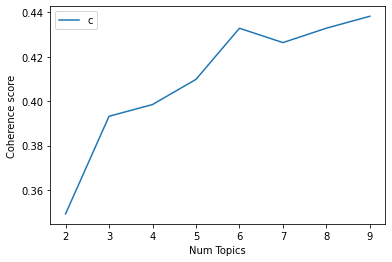

In [22]:
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3493
Num Topics = 3  has Coherence Value of 0.3932
Num Topics = 4  has Coherence Value of 0.3985
Num Topics = 5  has Coherence Value of 0.4098
Num Topics = 6  has Coherence Value of 0.4328
Num Topics = 7  has Coherence Value of 0.4264
Num Topics = 8  has Coherence Value of 0.4328
Num Topics = 9  has Coherence Value of 0.4382


In [24]:
# Select the model and print the topics
optimal_model = model_list[5] # canviar pel que vulgui
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.093*"wear" + 0.092*"great" + 0.060*"perfect" + 0.048*"comfortable" + '
  '0.030*"fall" + 0.026*"love" + 0.026*"summer" + 0.021*"pair" + 0.020*"piece" '
  '+ 0.019*"soft"'),
 (1,
  '0.074*"fabric" + 0.059*"make" + 0.049*"feel" + 0.046*"nice" + '
  '0.045*"material" + 0.036*"quality" + 0.027*"design" + 0.025*"good" + '
  '0.022*"high" + 0.021*"give"'),
 (2,
  '0.052*"long" + 0.045*"back" + 0.038*"short" + 0.031*"sleeve" + '
  '0.024*"length" + 0.023*"model" + 0.021*"front" + 0.021*"side" + '
  '0.021*"picture" + 0.021*"show"'),
 (3,
  '0.119*"color" + 0.097*"love" + 0.046*"beautiful" + 0.044*"buy" + '
  '0.035*"purchase" + 0.027*"black" + 0.026*"flattering" + 0.016*"white" + '
  '0.016*"detail" + 0.015*"soft"'),
 (4,
  '0.088*"small" + 0.055*"large" + 0.049*"run" + 0.036*"fit" + 0.035*"medium" '
  '+ 0.034*"big" + 0.032*"waist" + 0.029*"tight" + 0.022*"bit" + '
  '0.022*"bottom"'),
 (5,
  '0.149*"size" + 0.102*"fit" + 0.077*"order" + 0.036*"petite" + 0.034*"store" '
  '+ 0.028*

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['review_text']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['review_text'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.1693,"color, love, beautiful, buy, purchase, black, ...",Absolutely wonderful - silky and sexy and comf...
1,1,5.0,0.2648,"size, fit, order, petite, store, true, find, p...",Love this dress! it's sooo pretty. i happene...
2,2,5.0,0.2370,"size, fit, order, petite, store, true, find, p...",I had such high hopes for this dress and reall...
3,3,0.0,0.1673,"wear, great, perfect, comfortable, fall, love,...","I love, love, love this jumpsuit. it's fun, fl..."
4,4,0.0,0.2019,"wear, great, perfect, comfortable, fall, love,...",This shirt is very flattering to all due to th...
5,5,6.0,0.1759,"wear, cute, shirt, style, love, buy, sale, pri...","I love tracy reese dresses, but this one is no..."
6,6,5.0,0.2129,"size, fit, order, petite, store, true, find, p...",I aded this in my basket at hte last mintue to...
7,7,3.0,0.1818,"color, love, beautiful, buy, purchase, black, ...","I ordered this in carbon for store pick up, an..."
8,8,5.0,0.1754,"size, fit, order, petite, store, true, find, p...",I love this dress. i usually get an xs but it ...
9,9,5.0,0.1779,"size, fit, order, petite, store, true, find, p...","I'm 5""5' and 125 lbs. i ordered the s petite t..."


In [26]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,3.0,"color, love, beautiful, buy, purchase, black, ...",4163.0,0.1840
1.0,5.0,"size, fit, order, petite, store, true, find, p...",3032.0,0.1340
2.0,5.0,"size, fit, order, petite, store, true, find, p...",3052.0,0.1349
3.0,0.0,"wear, great, perfect, comfortable, fall, love,...",3150.0,0.1392
4.0,0.0,"wear, great, perfect, comfortable, fall, love,...",3539.0,0.1564
...,...,...,...,...
23481.0,NaN,NaN,NaN,NaN
23482.0,NaN,NaN,NaN,NaN
23483.0,NaN,NaN,NaN,NaN
23484.0,NaN,NaN,NaN,NaN


In [27]:
df_dominant_topic.Dominant_Topic.value_counts()

0.0    4163
4.0    3539
3.0    3150
5.0    3105
2.0    3052
1.0    3032
6.0    2587
Name: Dominant_Topic, dtype: int64

In [28]:
list(df_dominant_topic.loc[df_dominant_topic.Dominant_Topic==0]['Text'])[1]

'This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!'

In [29]:
df_final = pd.merge(df_dominant_topic, df['stars'], how='inner', left_index=True, right_index=True)
df_final.head()

KeyError: 'stars'

In [ ]:
df_final.groupby('Dominant_Topic').stars.value_counts()

In [ ]:
list(df_final.loc[(df_final.Dominant_Topic==0)&(df_final.stars==1)]['Text'])[4]